# Verbesserte Monte-Carlo-Simulation für 4 Jahre

Dieses Notebook führt eine verbesserte Monte-Carlo-Simulation durch, um Szenarien der Globalstrahlung zu generieren, zu analysieren und zu reduzieren. Dabei werden auch saisonale Effekte (monatlich/jährlich) betrachtet.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.cluster import KMeans

## 1. Laden und Vorbereiten der Daten

In diesem Schritt wird die CSV-Datei geladen und der Zeitstempel geparst. Außerdem werden die Spalten umbenannt und zusätzliche Spalten zur saisonalen Analyse erstellt.

In [5]:
def read_and_prepare_dataset(dataset_path):
    df = pd.read_csv(dataset_path)
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

    # Umbenennung der Spalten
    df = df.rename(columns={
        "G(i) (Globalstrahlung)": "global_radiation",
        "H_sun (Sonnenscheindauer in min)": "sunshine_duration",
        "T2m (Temperatur)": "temperature",
        "WS10m (Windgeschwindigkeit)": "wind_speed"
    })

    # Monatliche Gruppierung zur Analyse von Saisonalität
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month

    return df

# Passe den Pfad zur CSV-Datei an
df = read_and_prepare_dataset('Timeseries_2020_2023.csv')

# Zeige die ersten Zeilen an
df.head()

,time,global_radiation,sunshine_duration,temperature,wind_speed,year,month
0,2022-01-01 00:10:00,0.0,0.0,11.92,3.24,2022,1
1,2022-01-01 01:10:00,0.0,0.0,11.73,2.90,2022,1
2,2022-01-01 02:10:00,0.0,0.0,11.74,2.62,2022,1
3,2022-01-01 03:10:00,0.0,0.0,11.44,2.48,2022,1
4,2022-01-01 04:10:00,0.0,0.0,11.30,2.41,2022,1


## 2. Berechnung und Darstellung der PDF

Hier wird eine Kernel Density Estimation (KDE) verwendet, um die Wahrscheinlichkeitsdichtefunktion (PDF) der Globalstrahlung zu berechnen und zu visualisieren.

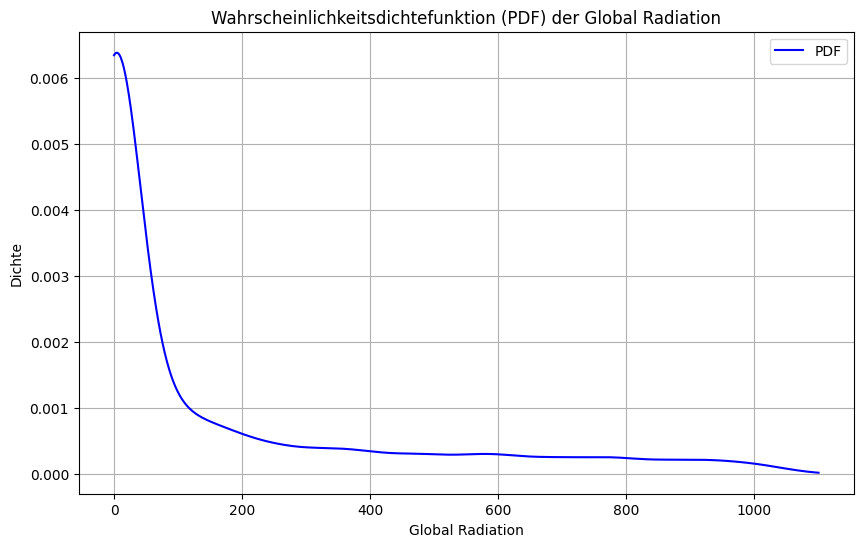

In [6]:
# Extrahiere die global_radiation-Daten
data = df['global_radiation'].values

# Berechne die KDE
kde = stats.gaussian_kde(data)
x_values = np.linspace(np.min(data), np.max(data), 1000)
pdf_values = kde(x_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values, pdf_values, label='PDF', color='blue')
plt.title('Wahrscheinlichkeitsdichtefunktion (PDF) der Global Radiation')
plt.xlabel('Global Radiation')
plt.ylabel('Dichte')
plt.legend()
plt.grid(True)
plt.show()

## 3. Darstellung der empirischen CDF

Die empirische kumulative Verteilungsfunktion (CDF) wird berechnet, indem die Daten sortiert und die kumulativen Wahrscheinlichkeiten bestimmt werden.

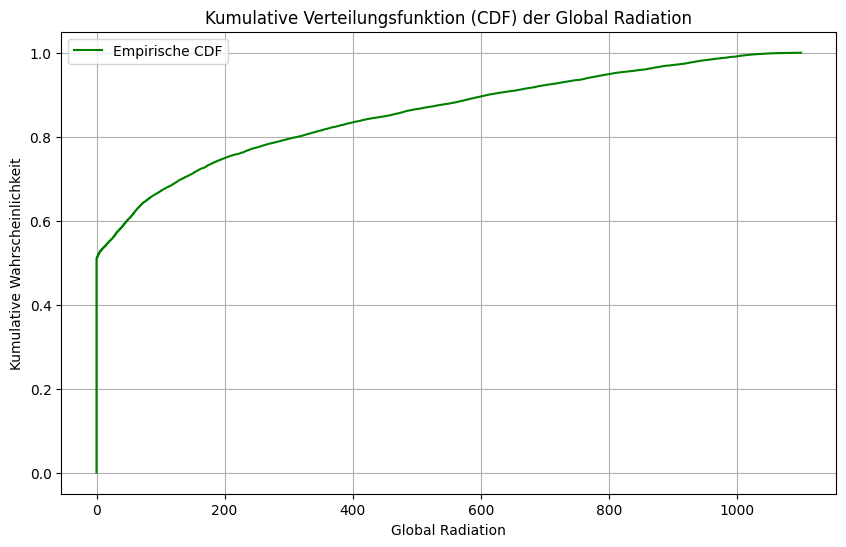

In [7]:
# Sortiere die Daten und berechne die empirische CDF
sorted_data = np.sort(data)
cdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(10, 6))
plt.plot(sorted_data, cdf_values, label='Empirische CDF', color='green')
plt.title('Kumulative Verteilungsfunktion (CDF) der Global Radiation')
plt.xlabel('Global Radiation')
plt.ylabel('Kumulative Wahrscheinlichkeit')
plt.legend()
plt.grid(True)
plt.show()

## 4. Monte-Carlo-Szenario-Generierung mittels inverser CDF

Hier werden Monte-Carlo-Szenarien generiert, indem für gleichverteilte Zufallszahlen das Inverse der empirischen CDF interpoliert wird.

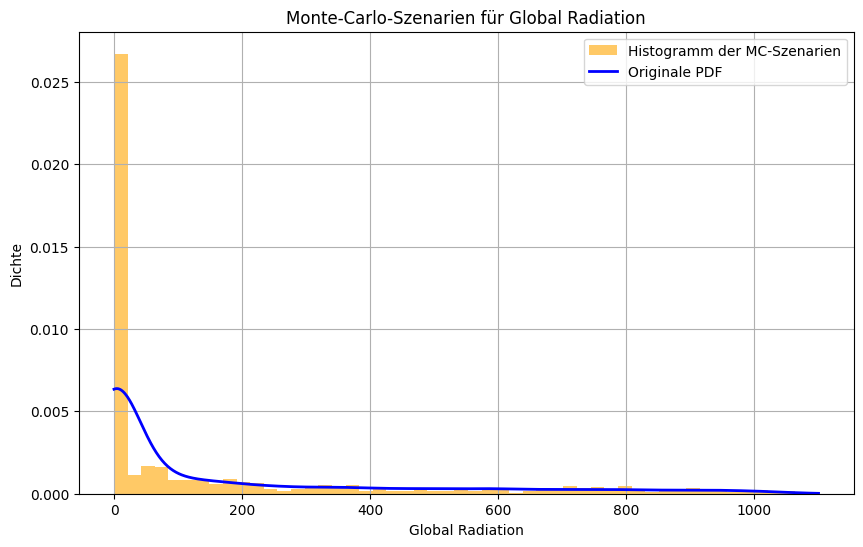

In [8]:
# Anzahl der zu generierenden Szenarien
n_samples = 1000

# Erzeuge gleichverteilte Zufallszahlen zwischen 0 und 1
uniform_samples = np.random.uniform(0, 1, n_samples)

# Nutze np.interp zur Interpolation der Quantile (inverse CDF)
mc_scenarios = np.interp(uniform_samples, cdf_values, sorted_data)

# Visualisierung der generierten Szenarien
plt.figure(figsize=(10, 6))
plt.hist(mc_scenarios, bins=50, density=True, alpha=0.6, label='Histogramm der MC-Szenarien', color='orange')
plt.plot(x_values, pdf_values, label='Originale PDF', color='blue', linewidth=2)
plt.title('Monte-Carlo-Szenarien für Global Radiation')
plt.xlabel('Global Radiation')
plt.ylabel('Dichte')
plt.legend()
plt.grid(True)
plt.show()

## 5. Szenarioreduktion mittels k-Means Clustering

Mit Hilfe des k-Means-Algorithmus werden die 1000 generierten Szenarien in 10 Cluster gruppiert. Die Cluster-Zentren dienen als repräsentative Szenarien, und die Wahrscheinlichkeiten werden aus den Clustergrößen abgeleitet.

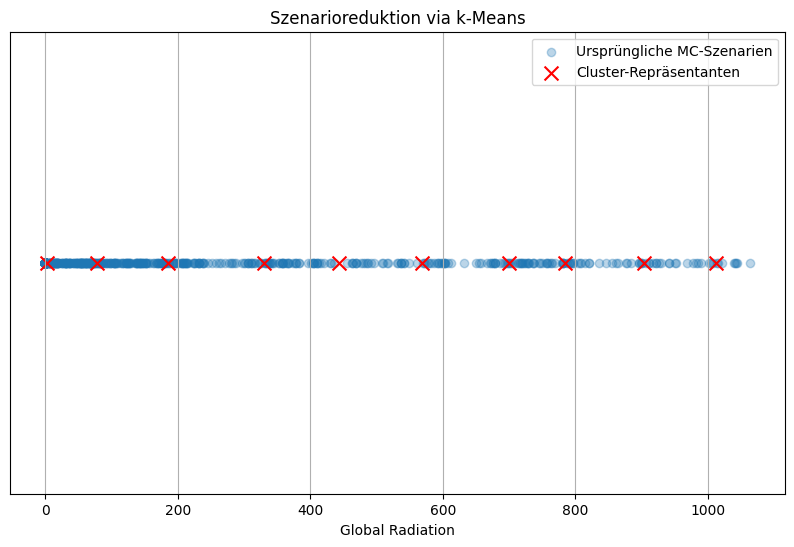

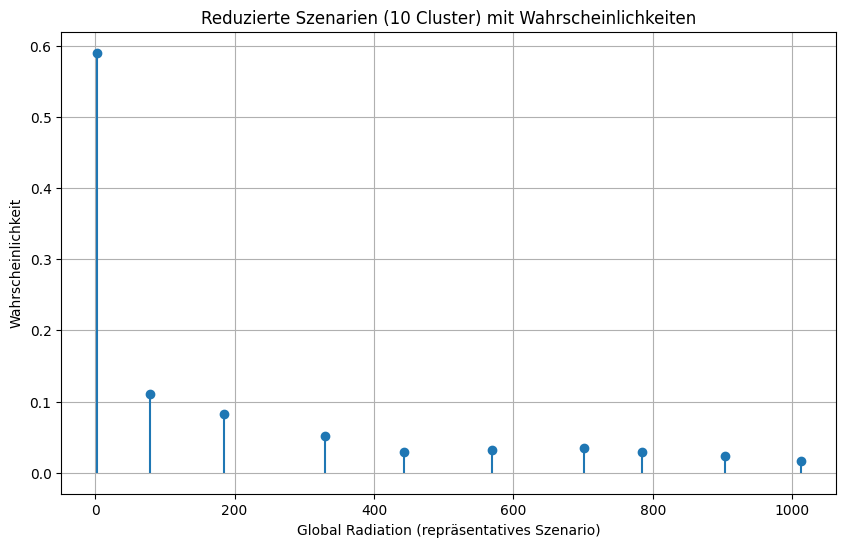

In [9]:
# Anzahl der ursprünglichen Szenarien und gleiche Wahrscheinlichkeit
num_scenarios = len(mc_scenarios)
original_prob = 1.0 / num_scenarios  # Alle Szenarien haben die gleiche Wahrscheinlichkeit

# Bestimme, wie viele Cluster (k) gewünscht sind
k = 10  # Beispiel: 10 repräsentative Szenarien

# KMeans-Clustering (KMeans erwartet 2D-Daten)
mc_scenarios_2d = mc_scenarios.reshape(-1, 1)
kmeans = KMeans(n_clusters=k, random_state=42).fit(mc_scenarios_2d)

# Cluster-Zuordnung und Clusterzentren
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_.flatten()

# Zähle, wie viele Szenarien pro Cluster fallen
unique, counts = np.unique(labels, return_counts=True)
counts_dict = dict(zip(unique, counts))

# Wahrscheinlichkeiten der Cluster berechnen
cluster_probs = [counts_dict[i] * original_prob for i in range(k)]

# Optional: Sortieren der Clusterzentren für eine übersichtliche Darstellung
sorted_indices = np.argsort(cluster_centers)
cluster_centers_sorted = cluster_centers[sorted_indices]
cluster_probs_sorted = np.array(cluster_probs)[sorted_indices]

# Visualisierung der Cluster und reduzierten Szenarien
plt.figure(figsize=(10, 6))

# (a) Scatter-Plot der ursprünglichen MC-Szenarien
plt.scatter(mc_scenarios, np.zeros_like(mc_scenarios),
            alpha=0.3, label='Ursprüngliche MC-Szenarien')

# (b) Plot der Clusterzentren als repräsentative Szenarien
plt.scatter(cluster_centers, np.zeros_like(cluster_centers),
            color='red', marker='x', s=100, label='Cluster-Repräsentanten')

plt.title('Szenarioreduktion via k-Means')
plt.xlabel('Global Radiation')
plt.yticks([])  # y-Achse ausblenden, da es sich um 1D-Daten handelt
plt.legend()
plt.grid(True)
plt.show()

# Visualisierung der Wahrscheinlichkeitsverteilung der reduzierten Szenarien
plt.figure(figsize=(10, 6))
plt.stem(cluster_centers_sorted, cluster_probs_sorted, basefmt=' ')
plt.title('Reduzierte Szenarien (10 Cluster) mit Wahrscheinlichkeiten')
plt.xlabel('Global Radiation (repräsentatives Szenario)')
plt.ylabel('Wahrscheinlichkeit')
plt.grid(True)
plt.show()

## 6. Erweiterte Cluster-Analyse: Tag des Jahres vs. Globalstrahlung

In diesem Abschnitt wird eine zusätzliche Spalte `day_of_year` (Tag des Jahres) erstellt und ein 1D-Clustering der Globalstrahlungsdaten durchgeführt. Anschließend wird ein Scatter-Plot erstellt, der den Tag des Jahres gegen die Globalstrahlung darstellt. Die Clusterzentren werden als horizontale Linien eingezeichnet.

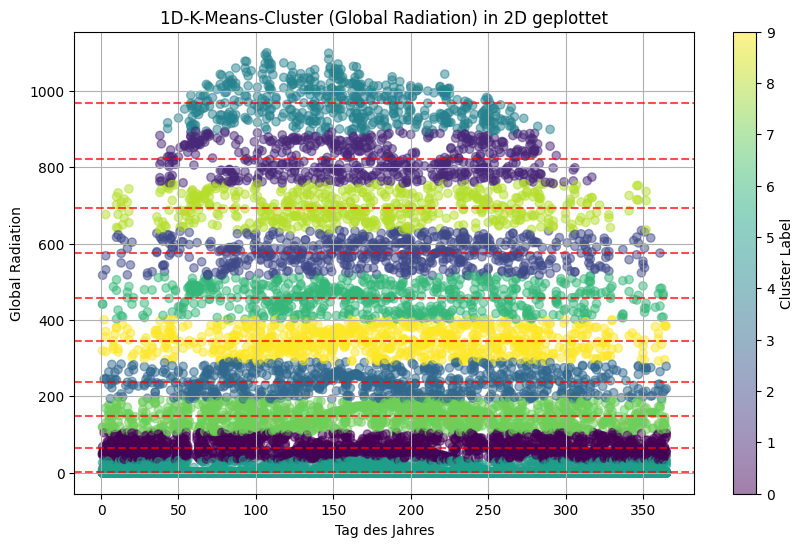

In [10]:
# Erstelle die Spalte 'day_of_year'
df['day_of_year'] = df['time'].dt.dayofyear

# Clustering basierend auf global_radiation (1D)
X_1d = df['global_radiation'].values.reshape(-1, 1)
k = 10  # Anzahl der Cluster
kmeans_1d = KMeans(n_clusters=k, random_state=42)
labels_1d = kmeans_1d.fit_predict(X_1d)

# Scatter-Plot: Tag des Jahres vs. Globalstrahlung
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    df['day_of_year'],          # x-Achse
    df['global_radiation'],     # y-Achse
    c=labels_1d,                # Cluster-Labels als Farbe
    cmap='viridis',
    alpha=0.5
)
plt.colorbar(scatter, label='Cluster Label')
plt.xlabel('Tag des Jahres')
plt.ylabel('Global Radiation')
plt.title('1D-K-Means-Cluster (Global Radiation) in 2D geplottet')
plt.grid(True)

# Anzeige der Clusterzentren als horizontale Linien
centers_1d = kmeans_1d.cluster_centers_.flatten()
for center in centers_1d:
    plt.axhline(center, color='red', linestyle='--', alpha=0.7)

plt.show()

# Speichern der repräsentativen Szenarien für das Lower-Level-Problem


In [11]:

# Erstelle ein DataFrame mit den repräsentativen Szenarien (Clusterzentren) und ihren Wahrscheinlichkeiten
scenario_data = pd.DataFrame({
    'scenario_id': range(1, k + 1),
    'global_radiation': cluster_centers_sorted,
    'probability': cluster_probs_sorted
})

# Speichere die Daten in einer CSV-Datei
scenario_data.to_csv('representative_scenarios.csv', index=False)
print("Die repräsentativen Szenarien wurden in 'representative_scenarios.csv' gespeichert.")


Die repräsentativen Szenarien wurden in 'representative_scenarios.csv' gespeichert.
